In [1]:
pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [3]:
(train_ds,val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


In [5]:
get_label_name = metadata.features['label'].int2str
[get_label_name(n) for n in range(5)]

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

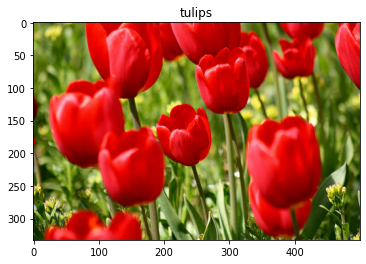

In [6]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_= plt.imshow(image)
_= plt.title(get_label_name(label))

In [7]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

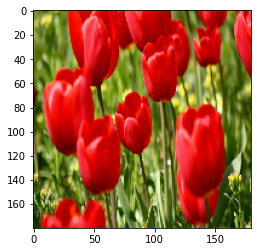

In [8]:
result = resize_and_rescale(image)
_= plt.imshow(result)

In [9]:
print('Min and max pixel values:', result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


In [10]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
image.shape

TensorShape([333, 500, 3])

In [12]:
image = tf.expand_dims(image,0)

In [13]:
image.shape

TensorShape([1, 333, 500, 3])

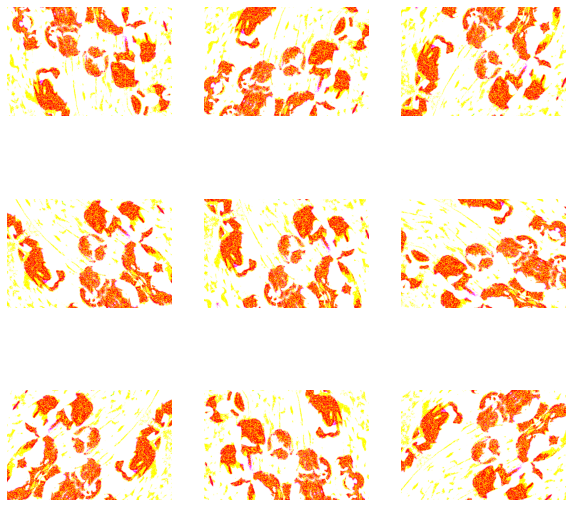

In [14]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis('off')

In [15]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
])

In [16]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y:(resize_and_rescale(x), y),
               num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.batch(batch_size)
        
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                   num_parallel_calls=AUTOTUNE)
        
    return ds.prefetch(buffer_size = AUTOTUNE)

In [17]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [20]:
epochs = 5
history = model.fit(train_ds, validation_data = val_ds,epochs=epochs)

Epoch 1/5
92/92 [==============================] - ETA: 0s - loss: 1.2489 - accuracy: 0.4676

ValueError: ignored

In [ ]:
loss, acc = model.evaluate(test_ds)
print('Accuracy', acc)